In [1]:
import torch
from torch import nn
from torch.utils.data import random_split, DataLoader 
from torchvision import transforms, datasets
from torchvision.transforms import v2
import os
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn import metrics
from torch import optim
import logging
from torchsummary import summary
import seaborn as sns

logging.basicConfig(encoding='utf-8')

DEVICE = 'cuda' if torch.cuda.is_available() else "cpu"
print('DEVICE = ', DEVICE)

c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may

DEVICE =  cuda


In [2]:
#PARAMS
BATCH_SIZE = 32 


In [3]:
custom_transform = v2.Compose([
    v2.ToTensor(),
    v2.Resize((224,224), antialias=True),
    v2.RandomHorizontalFlip(0.5),
    v2.RandomRotation(0.5),
    v2.ToDtype(torch.float32),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# train_dataset = datasets.ImageFolder(root = './cnn_dataset', transform = custom_transform)
# train_dataloader =  DataLoader(train_dataset, shuffle= True, num_workers= 4, batch_size = BATCH_SIZE)
# print('train_dataloader len = ',len(train_dataloader))

# features, labels = next(iter(train_dataloader))
# print('features shape = ', features.shape)
# print('labels shape = ', labels.shape)

class_dict = {
    0: 'Dog',
    1: 'Food',
    2: 'Vehicle'
}

c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


In [4]:
dataset = datasets.ImageFolder(root = './cnn_dataset', transform = custom_transform)
total_len = len(dataset)
train_ratio = 0.7
valid_ratio = 0.15
test_ratio = 0.15

train_size = int(total_len * train_ratio)
valid_size = int(total_len * valid_ratio)
test_size = int(total_len * test_ratio)

print('total len = ', total_len)
print()

train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])
print('train dataset len = ', len(train_dataset))
print('valid dataset len = ', len(valid_dataset))
print('test dataset len = ', len(test_dataset))

train_dataloader =  DataLoader(train_dataset, shuffle= True, num_workers= 4, batch_size = BATCH_SIZE)
val_dataloader =  DataLoader(valid_dataset, shuffle= True, num_workers= 4, batch_size = BATCH_SIZE)
test_dataloader =  DataLoader(test_dataset, shuffle= True, num_workers= 4, batch_size = BATCH_SIZE)

total len =  30000

train dataset len =  21000
valid dataset len =  4500
test dataset len =  4500


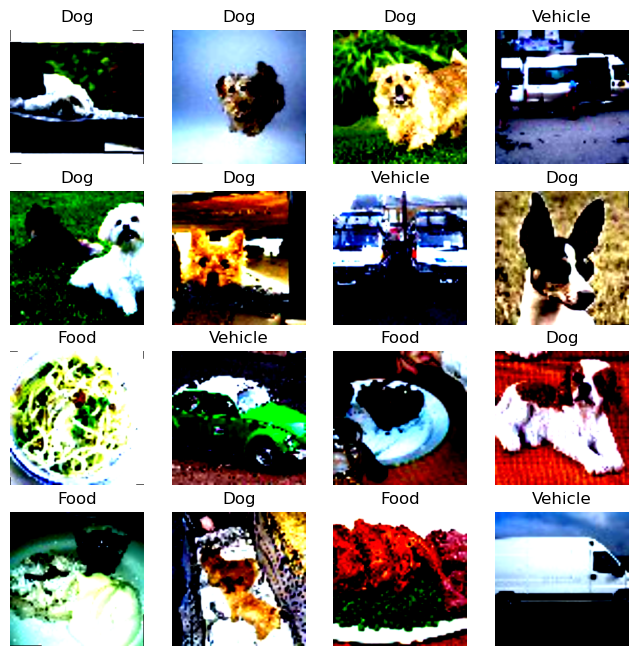

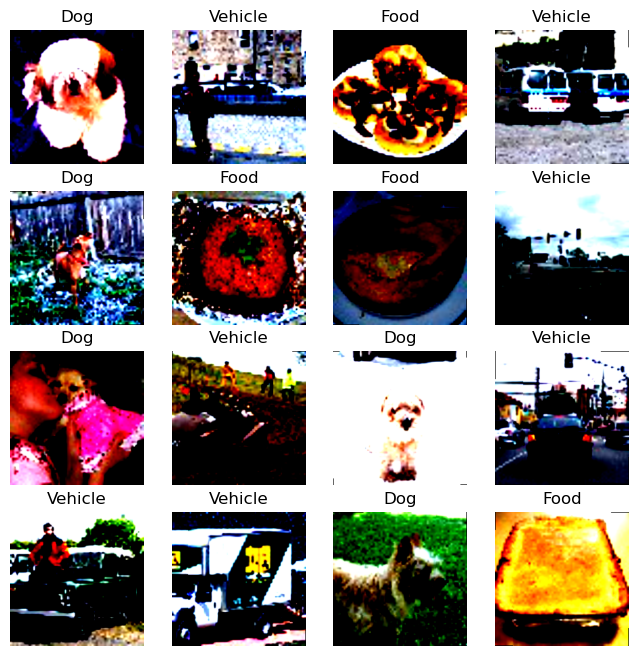

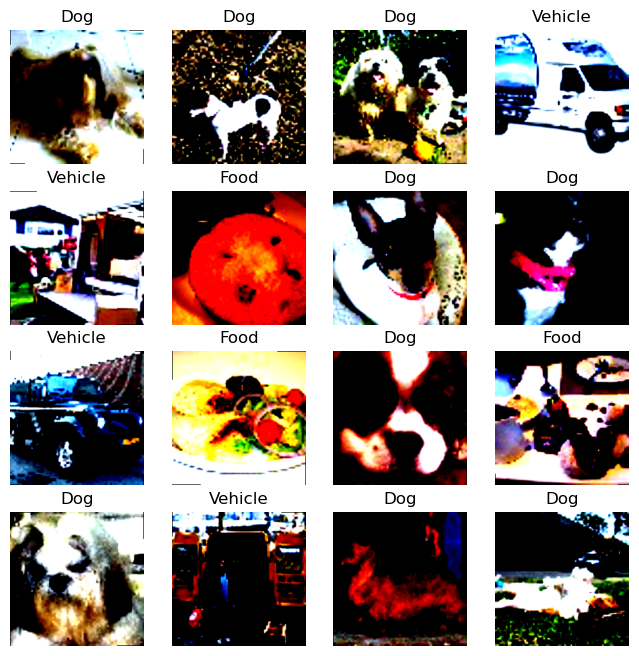

In [5]:
def sample_images(dataloader):
    features, labels = next(iter(dataloader))

    figure = plt.figure(figsize=(8,8))
    for i in range(16):
        figure.add_subplot(4, 4, i + 1)
        plt.imshow(np.transpose(features[i], (1,2,0)))
        plt.axis('off')
        plt.title(class_dict[labels[i].item()])

    plt.show()

sample_images(train_dataloader)
sample_images(val_dataloader)
sample_images(test_dataloader)

In [6]:
class Trainer():
    def __init__(self, log_level = logging.DEBUG):
        self.device = 'cuda' if torch.cuda.is_available() else "cpu"
        self.logger = logging.getLogger()
        self.logger.setLevel(log_level)
        self.logger.info('created trainer')

    def prepare_model(self, model, device):
        model.to(device)
        return model
    
    def prepare_batch(self, batch, device):
        features, labels = batch
        features = features.to(device)
        labels = labels.type(torch.LongTensor).to(device)
        return features, labels
    
    def score(self, score_fn, model, dataloader, device, criterion = None, name ='', **kwargs):
        y_pred = np.array([])
        y = np.array([])
        loop = tqdm(dataloader)
        loop.set_description(f'evaluating score {name}...')
        running_loss = 0.0 if criterion != None else None
        for batch in loop: 
            features, labels = self.prepare_batch(batch, device)
            outputs = model(features)

            #get loss values if criterion not None 
            if criterion:
                loss = criterion(outputs, labels)
                running_loss += loss.item()

            outputs = torch.argmax(outputs, dim = 1).detach().cpu().numpy().reshape(-1)
            labels = labels.detach().cpu().numpy().reshape(-1)
            y_pred = np.concatenate((y_pred, outputs))
            y = np.concatenate((y, labels))
        
        return score_fn(y_pred, y, **kwargs), running_loss 

    def confusion_matrix(self, model, dataloader, device, **kwwargs):
        y_pred = np.array([])
        y = np.array([])
        for batch in dataloader:
            features, labels = self.prepare_batch(batch, device)
            outputs = model(features)
            outputs = torch.argmax(outputs, dim = 1).detach().cpu().numpy().reshape(-1)
            labels = labels.detach().cpu().numpy().reshape(-1)
            y_pred = np.concatenate((y_pred, outputs))
            y = np.concatenate((y, labels))

        cm = metrics.confusion_matrix(y_pred, y)
        sns.heatmap(cm, annot = True)
    
    def performance_plot(self, history):
        train_loss =[]
        val_loss =[]
        test_loss =[]
        train_acc = []
        val_acc = []
        test_acc = []

        for hist in history:
            train_loss.append(hist['train_loss'])
            val_loss.append(hist['val_loss'])
            test_loss.append(hist['test_loss'])
            train_acc.append(hist['train_accuracy'])
            val_acc.append(hist['val_accuracy'])
            test_acc.append(hist['test_accuracy'])
        
        fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
        e = list(range(len(history)))
        
        sns.lineplot(x = e, y = train_loss, label = 'train loss', ax = ax1)
        sns.lineplot(x = e, y = val_loss, label = 'val loss', ax = ax1)
        sns.lineplot(x = e, y = test_loss, label = 'test loss', ax = ax1)
        sns.lineplot(x = e, y = train_acc, label = 'train accuracy', ax = ax2)
        sns.lineplot(x = e, y = val_acc, label = 'val accuracy', ax = ax2)
        sns.lineplot(x = e, y = test_acc, label = 'test accuracy', ax = ax2)
        plt.show()
        

    def train(self, model, optim, criterion,  train_dataloader, val_dataloader, \
              test_dataloader, device = None, epochs = 10, save_path = None):

        if device == None:
            device = self.device

        self.logger.info(f"DEVICE = {device}")

        history = []
        self.logger.info('preparing model for training ... ')
        model = self.prepare_model(model, device)

        self.logger.info('training ... ')

        best_score = 0

        for e in range(epochs):
            loop = tqdm(train_dataloader)

            total_train_loss = 0
            total_valid_loss = 0
            total_test_loss = 0
            loop.set_description(f'training epoch {e}\t\t')

            y_pred = np.array([])
            y = np.array([])
            model.train()

            for batch in loop:
                features, labels = self.prepare_batch(batch, device)

                outputs = model(features)

                optim.zero_grad()
                loss = criterion(outputs, labels)
                loss.backward()
                optim.step()

                total_train_loss += loss.item()

            model.eval()
            train_accuracy, train_loss = self.score(metrics.accuracy_score, model, train_dataloader, device, criterion=criterion, name = 'train')
            val_accuracy, val_loss = self.score(metrics.accuracy_score, model, val_dataloader, device, criterion=criterion, name = 'valid')
            test_accuracy, test_loss = self.score(metrics.accuracy_score, model, test_dataloader, device, criterion=criterion, name = 'test')

            self.logger.debug(f'\n\
                            epoch = {e}\n\
                            =============\n\
                            train_loss = {train_loss:.2f}\n\
                            train_accuracy = {train_accuracy:.2f}\n\
                            val loss = {val_loss:.2f}\n\
                            valid_accuracy = {val_accuracy:.2f}\n\
                            test loss = {test_loss:.2f}\n\
                            test_accuracy = {test_accuracy:.2f}\n\
                            bets_accuracy = {best_score:.2f}\n\
                            ')
            history.append({
                'train_loss': train_loss,
                'train_accuracy': train_accuracy,
                'val_loss': val_loss,
                'val_accuracy': val_accuracy,
                'test_loss': test_loss,
                'test_accuracy': test_accuracy,
            })
            
            if best_score < test_accuracy:
                best_score = test_accuracy

                if save_path:
                    self.logger.info(f"saved best score model at checkpoint.{save_path}")
                    torch.save(model, 'checkpoint.' + save_path)

        self.logger.info("done training ...")

        return model, history 


### Resnet

In [7]:
#Building ResNet
class ResnetBlockScratch(nn.Module):
    def __init__(self, out_channels, is_residual = False):
        super().__init__()
        self.is_residual = is_residual

        if is_residual:
            self.conv1 = nn.LazyConv2d(out_channels, kernel_size=3, stride = 2, padding = 1)
            self.res_conv = nn.Sequential(
                nn.LazyConv2d(out_channels, kernel_size=1, stride = 2),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.conv1 = nn.LazyConv2d(out_channels, kernel_size=3, stride = 1, padding = 1)
            self.res_conv = nn.Sequential()

        self.conv2 = nn.LazyConv2d(out_channels, kernel_size=3, stride = 1, padding = 1)
        self.batchnorm1 = nn.BatchNorm2d(out_channels)
        self.batchnorm2 = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        res_connection = self.res_conv(x)
        # print('res connection shape = ', res_connection.shape)
        x = nn.functional.relu(self.batchnorm1(self.conv1(x)))
        # print('conv1 output shape  ', x.shape)
        x = nn.functional.relu(self.batchnorm2(self.conv2(x)))
        # print('conv2 output shape  ', x.shape)
        x = x + res_connection
        # print('conv2 + res connection shape  ', x.shape)
        return nn.functional.relu(x)
    


In [8]:
# Test resnet block
# resnetblock =  ResnetBlockScratch(3,3)
# x = torch.rand((3,3,24,24))
# output = resnetblock(x)
# print(output.shape)

resnetblock =  ResnetBlockScratch(128,True)
x = torch.rand((10,64,56,56))
output = resnetblock(x)
print('res connection shape = ', output.shape)

res connection shape =  torch.Size([10, 128, 28, 28])


c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [9]:
class Resnet18Scratch(nn.Module):

    def __init__(self, num_class = 3):
        super().__init__()
        self.model = nn.Sequential(
            #layer 0
            nn.LazyConv2d(64,kernel_size = 7, stride = 2, padding = 3),
            nn.MaxPool2d(kernel_size=3, stride = 2, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # #layer 1 with resnet block
            ResnetBlockScratch(64),
            ResnetBlockScratch(64),
            # #layer 2
            ResnetBlockScratch(128, True),
            ResnetBlockScratch(128),
            # #layer 3
            ResnetBlockScratch(256, True),
            ResnetBlockScratch(256),
            # #layer 4
            ResnetBlockScratch(512, True),
            ResnetBlockScratch(512),
            # #Dense layer
            nn.Flatten(),
            nn.LazyLinear(num_class),
            nn.Softmax()
        )
    
    def forward(self, x):
        return self.model(x)

In [10]:
model = Resnet18Scratch(num_class=3)
model.to(DEVICE)

summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
         MaxPool2d-2           [-1, 64, 56, 56]               0
       BatchNorm2d-3           [-1, 64, 56, 56]             128
              ReLU-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,928
       BatchNorm2d-6           [-1, 64, 56, 56]             128
            Conv2d-7           [-1, 64, 56, 56]          36,928
       BatchNorm2d-8           [-1, 64, 56, 56]             128
ResnetBlockScratch-9           [-1, 64, 56, 56]               0
           Conv2d-10           [-1, 64, 56, 56]          36,928
      BatchNorm2d-11           [-1, 64, 56, 56]             128
           Conv2d-12           [-1, 64, 56, 56]          36,928
      BatchNorm2d-13           [-1, 64, 56, 56]             128
ResnetBlockScratch-14           [-1, 64

c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\torch\nn\modules\container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [11]:
with torch.no_grad():
    torch.cuda.empty_cache()

INFO:root:created trainer
INFO:root:DEVICE = cuda
INFO:root:preparing model for training ... 
INFO:root:training ... 
training epoch 0		:   0%|          | 0/657 [00:00<?, ?it/s]

evaluating score valid...:   0%|          | 0/141 [00:00<?, ?it/s]c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\torch\nn\modules\container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
evaluating score test...:   0%|          | 0/141 [00:00<?, ?it/s]c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\torch\nn\modules\container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
evaluating score test...: 100%|██████████| 141/141 [00:25<00:00,  5.56it/s]
DEBUG:root:
                            epoch = 0
                            train_loss = 473.91
                            train_accuracy = 0.83
                            val loss = 101.77
                            valid_accuracy = 0.83
                            test loss = 101.74
                            test_a

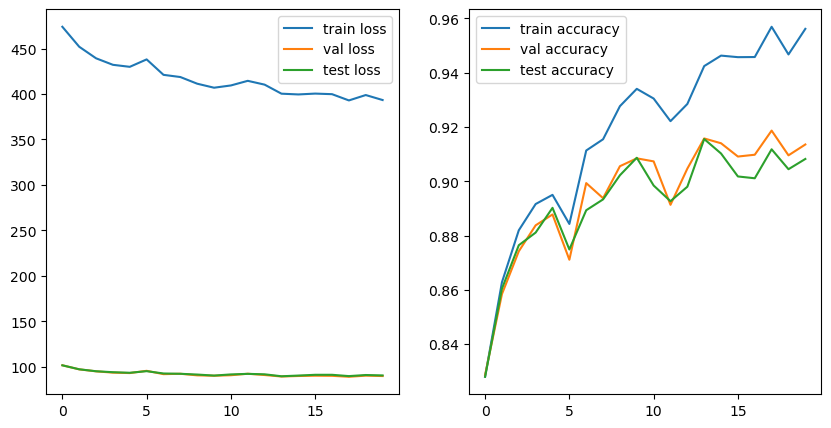

In [12]:
torch.cuda.empty_cache()

resnet = Resnet18Scratch(num_class=3)
resnet.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optim = torch.optim.SGD(resnet.parameters(), lr = 0.001)
trainer = Trainer()

resnet,history = trainer.train(resnet, optim, criterion, \
                              train_dataloader = train_dataloader, \
                              val_dataloader = val_dataloader, \
                              test_dataloader = test_dataloader, \
                              epochs = 20)

trainer.performance_plot(history)

torch.save(resnet, 'resnet.h5')

In [13]:
torch.save(resnet, 'resnet18.h5')

c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\torch\nn\modules\container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x00000226823768E0>


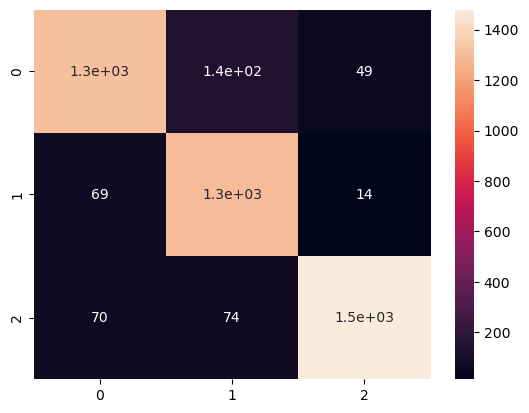

In [14]:
trainer.confusion_matrix(resnet, test_dataloader, device = DEVICE)